In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math
import json
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm


from utils import *
from autoencoder import Autoencoder
from diffusion_networks import *
from sampler import *

In [2]:
# Defining the constants and configurations used throughout the notebook.
k = 50
batch_size = 32 # 256 Largest possible batch size that fits on the GPU w.f32
on_remote = False
spacing = 10

iterations = 2101000
spinup = 1001
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')

#ae-2ds-32f-1l-150e-L1-0wd-0.00001l1
mean_data_latent = -0.6132266521453857
std_data_latent = 5.066834926605225
std_residual_latent =5.375336170196533

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [3]:
train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
#test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
shuffled_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)

# Load Models

In [5]:
autoencoder_date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{autoencoder_date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{autoencoder_date}/{autoencoder_model}/')
saved_model = torch.load(autoencoder_path / 'best_model.pth')

with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)
autoencoder.load_state_dict(saved_model)
autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [6]:
diffusion_date = '2024-02-29'
result_model = f'ncsnpp-f32-k{k}'

result_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{diffusion_date}/{result_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{diffusion_date}/{result_model}/')
saved_model = torch.load(result_path / 'best_model.pth')

with open(result_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
model_name = parameters['model']
k = parameters['k']

forecasting = True
model = GCPrecond(filters=filters, img_channels=2 if forecasting else 1, model=model_name, img_resolution = 16)

model.load_state_dict(saved_model)
model.to(device)
model.eval()
print("Diffusion Model loaded successfully!")

Diffusion Model loaded successfully!


In [21]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for current, next in train_loader:
            # Get the input data from the batch
            latent = autoencoder.encoder(current)
            next_latent = autoencoder.encoder(next)
            
            inputs = next_latent -  latent

            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        print("Mean:", mean_data_latent.item())
        print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent, std_residual_latent)

Mean: -6.831114205851918e-06
Standard Deviation: 5.375336170196533
-0.03832172974944115 1.3086596727371216 6.599302768707275


# Training Diffusion

### Sampling for training (Change)

In [ ]:
def sample_and_plot(net, class_labels = None, img_channels=1):
    sampler_fn = complete_edm_sampler
    
    latents = torch.randn([1, img_channels, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    # TODO Fix such that you can plot smaller resolutions
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()
    
sample_and_plot(model, img_channels=2)

In [ ]:
def plot_forecasts_from_residual(model, num_images=4):
    for previous, current in train_loader:
        with torch.no_grad():
            previous_latent = autoencoder.encoder(previous)
        
        previous_latent = previous_latent[0].unsqueeze(0)
        break

    img_channels = previous_latent.size(1)
    class_labels = previous_latent.repeat(num_images, 1, 1, 1)

    sampler_fn = edm_sampler
    latents = torch.randn([num_images, img_channels, model.img_resolution, model.img_resolution], device=device)
    
    residuals = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    predicted_latent = previous_latent + residuals * std_residual_latent

    predicted = autoencoder.decoder(predicted_latent.to(torch.float32)).cpu().detach().numpy()[:,0]
    previous = previous[0,0].cpu().detach().numpy()
    current = current[0,0].cpu().detach().numpy()

    vmin = min(predicted.min(), current.min(), previous.min())
    vmax = max(predicted.max(), current.max(), previous.max())

    fig, axes = plt.subplots(1, 2+num_images, figsize=(15, 5))

    axes[0].imshow(previous, vmin=vmin, vmax=vmax)
    axes[0].axis('off')
    axes[0].set_title('Previous')

    axes[1].imshow(current, vmin=vmin, vmax=vmax)
    axes[1].axis('off')
    axes[1].set_title('Truth')

    for i in range(num_images):
        axes[i+2].imshow(predicted[i], vmin=vmin, vmax=vmax)
        axes[i+2].axis('off')
        axes[i+2].set_title('Sampled')

    plt.tight_layout()
    plt.show()

plot_forecasts_from_residual(model)

### Training (Change)

In [8]:
# Setup for training

forecasting = True

num_epochs = 1

model = GCPrecond(filters=32, img_channels=2 if forecasting else 1, img_resolution = 16)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
#optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
loss_fn = GCLoss()

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1000)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  3541473


In [9]:
# Training
import time
from tqdm import tqdm

# Training loop

log_interval = 100#len(train_loader) // 4

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    current_loss = 0
    count = 0

    for previous, current in tqdm(train_loader):
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
        loss = loss_fn(model, target_latent, previous_latent)

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            # Calculate and log the current average loss
            current_loss = current_loss / count

            print(f'Average Loss: {current_loss:.4f}')

            current_loss = 0
            count = 0
        
        warmup_scheduler.step()

            
    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in tqdm(val_loader):
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
            loss = loss_fn(model, target_latent, previous_latent)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    
    scheduler.step()
        
    if forecasting:
        #plot_ensemble(model)
        #plot_forecasts_from_residual(model)
        pass
    else:
        pass
        #sample_and_plot(model, img_channels=1)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')
    torch.save(model.state_dict(), 'final_model.pth')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/5250 [00:00<?, ?it/s]

torch.Size([32, 1, 65, 65])


  0%|          | 0/5250 [00:19<?, ?it/s]


KeyboardInterrupt: 

# Generation

In [7]:
def generate_ensemble_from_single_random(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler):
    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0)
        current_unbatched = current[0].unsqueeze(0)
        break


    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)
        
        predicted_residuals = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * std_residual_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)

In [8]:
def generate_ensemble_from_batch(model, previous, n_ens=10, sampler_fn=edm_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous)
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

        latents = torch.randn_like(class_labels, device=device)

        predicted_residuals = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

        predicted_latent = class_labels + predicted_residuals * std_residual_latent
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ensemble_from_batch(model, next(iter(shuffled_val_loader))[0], n_ens=10)

# Evaluation

### Calculation functions

Batched input (n_ens, batch_size, img_channels, img_resolution, img_resolution)

In [9]:
from calculations import *

In [10]:
def calculate_nwp_skill(n_batches=2):
    count = 0

    results = {'skill': []}

    for (previous, current), nwp in zip(val_loader, nwp_loader):
   
        if count >= n_batches:
            break

        current_unnormalized = current * std_data + mean_data

        skill = calculate_RMSE(nwp, current_unnormalized).flatten()
        results['skill'].append(skill)

        count += 1

    results = {key: np.concatenate(value) for key, value in results.items()}

    # Just return skill for now
    return results['skill']

In [11]:
# This does work for unbatched data currently
forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=100, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)
skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
crps = calculate_CRPS(forecast, truth)
brier = calculate_brier_score(forecast, truth, 20)

print(f"Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.0f}, Brier: {brier[0]:.4f}")

Skill: 2.17, Spread: 2.01, Ratio: 0.930, CRPS: 140, Brier: 0.0044


### Main Plots

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 1/657 [00:13<2:29:30, 13.67s/it]


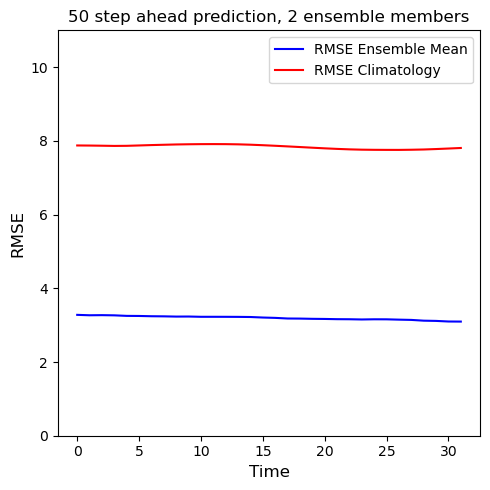

In [16]:
def rmse_plot(model, n_ens=1, n_batches=1, selected_loader=val_loader):
    model.eval()

    result = {}
    result['rmse_model'] = np.zeros(n_batches*batch_size)
    result['rmse_clim'] = np.zeros(n_batches*batch_size)

    with torch.no_grad():
        for count, (previous, current) in enumerate(tqdm(selected_loader)):
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, n_ens=n_ens)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            #  Note that this is kind of cheating since we are using the validation set to calculate the climatology.
            #  More realistic if we have a larger batch size.
            climatology = previous_unnormalized.mean(dim=0, keepdim=True)

            ensemble_mean = predicted_unnormalized.mean(dim=0)

            rmse_model = calculate_RMSE(ensemble_mean, current_unnormalized)
            rmse_clim = calculate_RMSE(climatology, current_unnormalized)

            result['rmse_model'][count*batch_size:count*batch_size+rmse_model.size] = rmse_model.flatten()
            result['rmse_clim'][count*batch_size:count*batch_size+rmse_model.size] = rmse_clim.flatten()

    return result


n_ens = 2
n_batches = 1
running_mean = 100

result = rmse_plot(model, n_ens, n_batches)
rmse_model, rmse_clim = result['rmse_model'], result['rmse_clim']

plt.figure(figsize=(5,5))
plt.title(f'{k} step ahead prediction, {n_ens} ensemble members')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='RMSE Ensemble Mean', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='RMSE Climatology', color='r')
plt.ylim(0,11)
plt.xlabel('Time', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

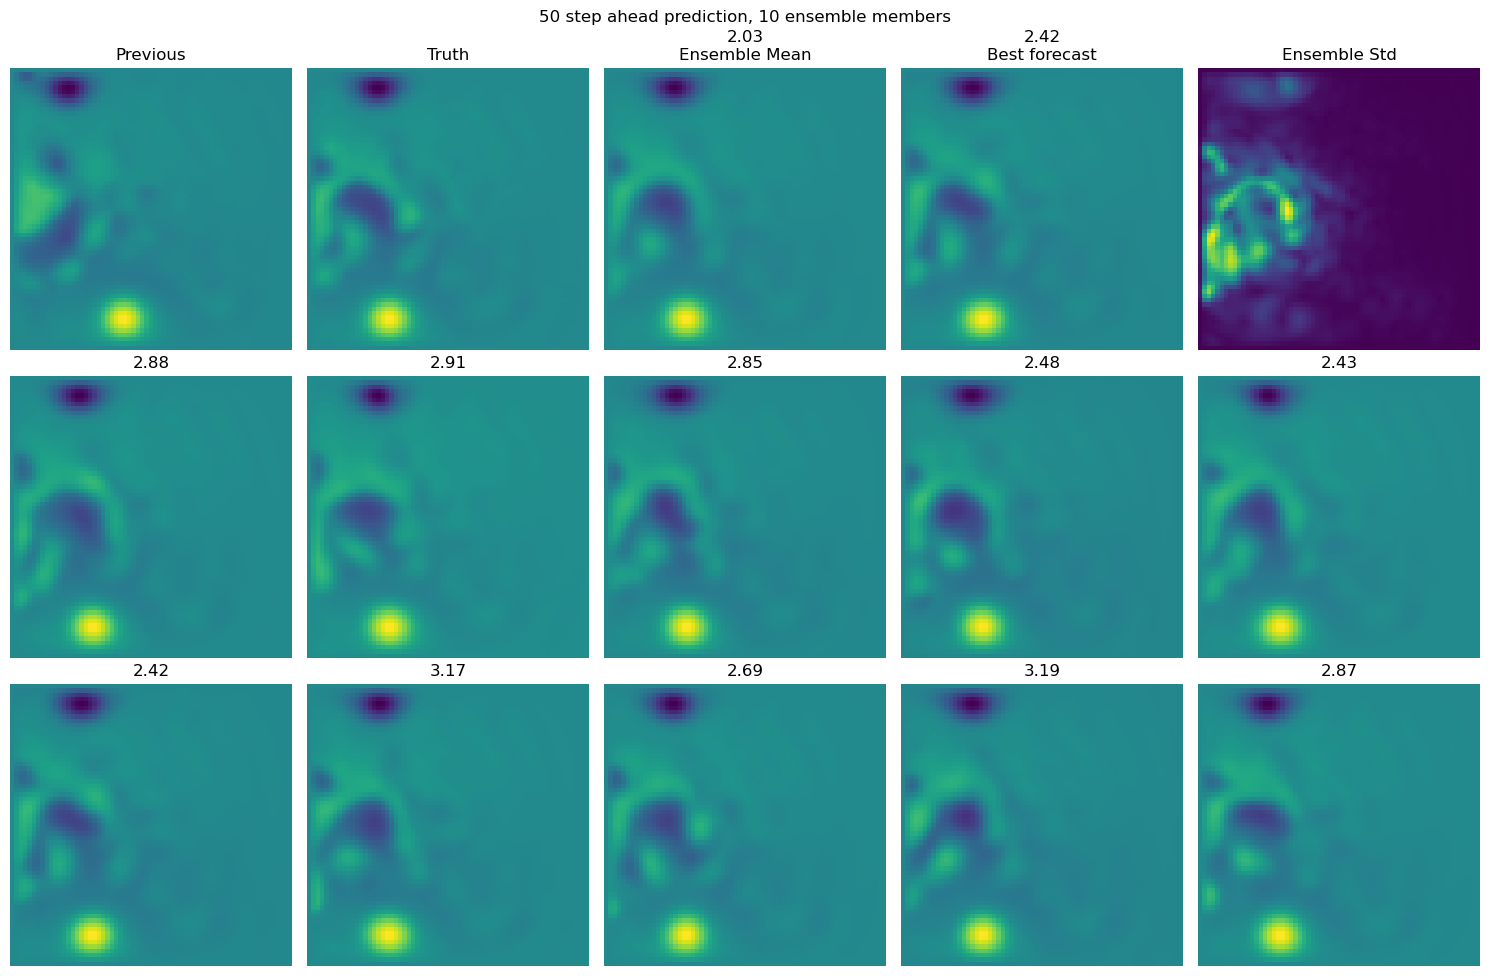

In [17]:
def ensemble_plot(model, selected_loader=shuffled_val_loader, n_ens=10):
    
    predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens, selected_loader)

    ensemble_mean = predicted_unnormalized.mean(dim=0, keepdim=True)
    ensemble_rmses = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
    ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
    ensemble_std = predicted_unnormalized.std(dim=0)

    best_forecast = predicted_unnormalized[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    def plot_image(ax, image, title):
        image = image.cpu().detach().numpy().reshape((65,65))
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')

    plt.set_cmap('viridis')
    no_ens_rows = 2

    fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
    fig.suptitle(f'{k} step ahead prediction, {n_ens} ensemble members')

    plot_image(axes[0,0], previous_unnormalized, "Previous")
    plot_image(axes[0,1], current_unnormalized, "Truth")
    plot_image(axes[0,2], ensemble_mean, f"{ensemble_skill:.2f}\nEnsemble Mean")
    plot_image(axes[0,3], best_forecast, f"{best_rmse:.2f}\nBest forecast")
    plot_image(axes[0,4], ensemble_std, "Ensemble Std")

    count = 0
    for i in range(no_ens_rows):
        for j in range(5):
            plot_image(axes[1+i,j], predicted_unnormalized[count], f"{ensemble_rmses[count]:.2f}")
            count+=1
    
    plt.tight_layout()
    plt.show()
    
    return ensemble_rmses, ensemble_skill

ensemble_rmses, ensemble_skill = ensemble_plot(model, selected_loader=shuffled_val_loader, n_ens=10)


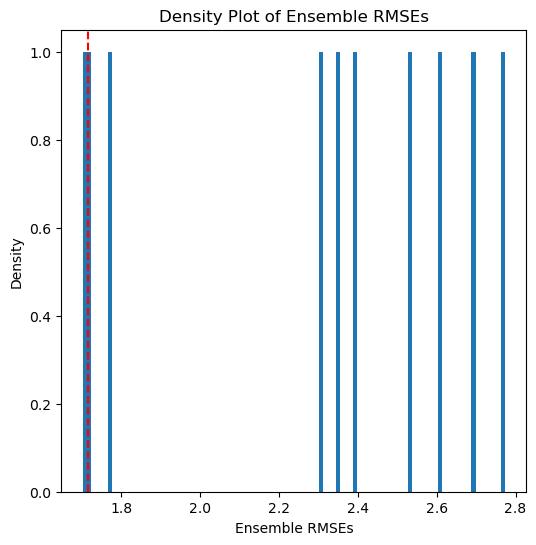

In [18]:
def rmse_density_plot(ensemble_rmses, ensemble_skill):
    plt.figure(figsize=(6,6))
    plt.hist(ensemble_rmses, bins=100)
    plt.axvline(ensemble_skill, color='red', linestyle='--')
    plt.xlabel('Ensemble RMSEs')
    plt.ylabel('Density')
    plt.title('Density Plot of Ensemble RMSEs')
    plt.show()

rmse_density_plot(ensemble_rmses, ensemble_skill)

### Evaluation Pipeline

In [11]:
def evaluation_pipeline(model, n_ens=10, n_batches=1, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    results = {
                'skill': np.zeros(n_batches*batch_size),
                'spread': np.zeros(n_batches*batch_size),
                'ratio': np.zeros(n_batches*batch_size),
                'crps': np.zeros(n_batches*batch_size),
                'brier': np.zeros(n_batches*batch_size),
                'covtrace': np.zeros(n_batches*batch_size)
                }
    
    results['rmse'] = np.zeros((n_ens, n_batches*batch_size))

    with torch.no_grad():
        for count, (previous, current) in (enumerate(tqdm(selected_loader))):
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, n_ens=n_ens)

            current_unnormalized = current * std_data + mean_data

            rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized)

            skill, spread, ratio = calculate_skill_and_spread_score(predicted_unnormalized, current_unnormalized)
            crps = calculate_CRPS(predicted_unnormalized, current_unnormalized)
            brier = calculate_brier_score(predicted_unnormalized, current_unnormalized, 20)
            covtrace = calculate_covtrace(predicted_unnormalized)
            
            # Can make this easier by preallocating results
            results['skill'][count*batch_size:(count+1)*batch_size] = skill
            results['spread'][count*batch_size:(count+1)*batch_size] = spread
            results['ratio'][count*batch_size:(count+1)*batch_size] = ratio
            results['crps'][count*batch_size:(count+1)*batch_size] = crps
            results['brier'][count*batch_size:(count+1)*batch_size] = brier
            results['covtrace'][count*batch_size:(count+1)*batch_size] = covtrace

            results['rmse'][:,count*batch_size:(count+1)*batch_size] = rmse

    return results

#res = evaluation_pipeline(model, n_ens=3, n_batches=2, selected_loader=val_loader, sampler_fn=edm_sampler)

### Various Time Series Plots

In [14]:
n_batches = 1
n_ens = 100
res = evaluation_pipeline(model, n_ens=n_ens, n_batches=n_batches, selected_loader=val_loader, sampler_fn=edm_sampler)

skill, spread, ratio, crps, brier, rmse, covtrace = res['skill'], res['spread'], res['ratio'], res['crps'], res['brier'], res['rmse'], res['covtrace']

nwp_skill = calculate_nwp_skill(n_batches=n_batches)

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [04:05<?, ?it/s]


KeyboardInterrupt: 

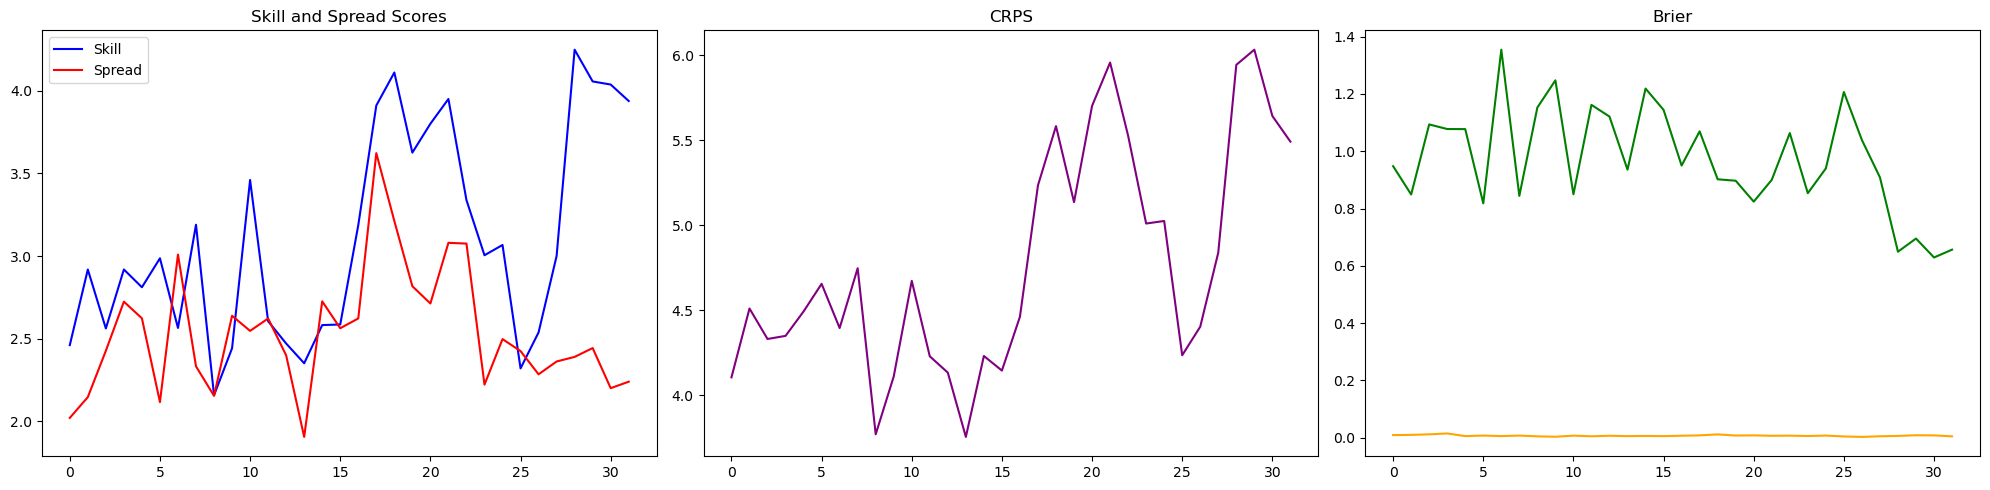

In [20]:
# Basic Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(res['skill'], label='Skill', color='blue')
axes[0].set_title('Skill and Spread Scores')
axes[0].plot(res['spread'], label='Spread', color='red')
axes[0].legend()

axes[2].plot(res['ratio'], label='Ratio', color='green')
axes[2].set_title('Ratio')

axes[1].plot(res['crps'], label='CRPS', color='purple')
axes[1].set_title('CRPS')

axes[2].plot(res['brier'], label='Brier', color='orange')
axes[2].set_title('Brier')

plt.tight_layout()

plt.show()

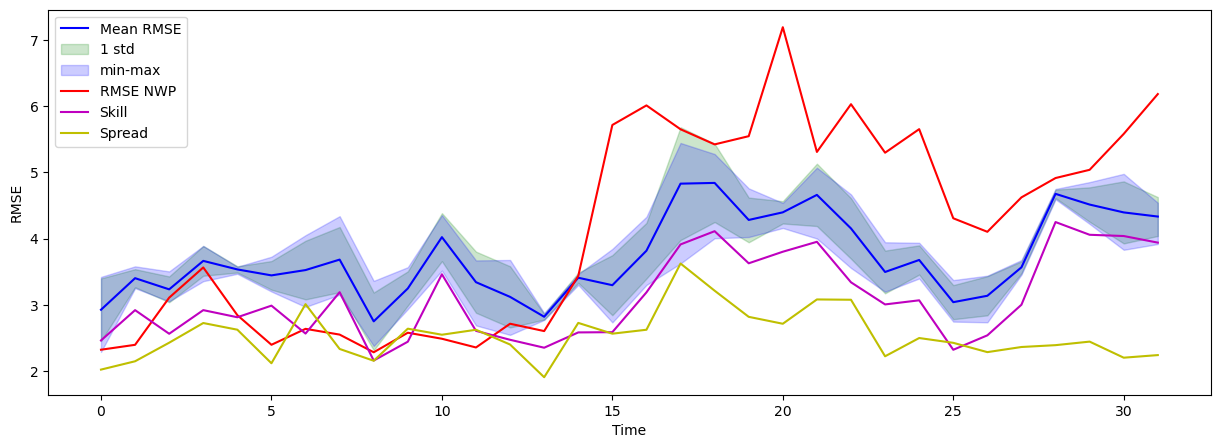

In [21]:
plt.figure(figsize=(15,5))

# Calculate the mean and standard deviation of rmse_model
mean_rmse = np.mean(rmse, axis=0)
std_rmse = np.std(rmse, axis=0)
min_rmse = np.min(rmse, axis=0)
max_rmse = np.max(rmse, axis=0)

# Plot the mean line
plt.plot(mean_rmse, label='Mean RMSE', color='blue')

# Plot the standard deviation band
plt.fill_between(range(len(mean_rmse)), mean_rmse - std_rmse, mean_rmse + std_rmse, alpha=0.2, color='green', label="1 std")
plt.fill_between(range(len(mean_rmse)), min_rmse, max_rmse, alpha=0.2, color='blue', label="min-max")
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('RMSE')

# Show the plot

#plt.plot(rmse_model, label='RMSE Model', linewidth=0.05)
plt.plot(nwp_skill, label='RMSE NWP', color='r')
#plt.plot(var_model, label='Var Model', color='g')
plt.plot(skill, label='Skill', color='m')
plt.plot(spread, label='Spread', color='y')
#plt.plot(crps, label='CRPS Model', color='c')
#plt.plot(brier, label='Brier Model', color='k')
plt.legend()
plt.show()

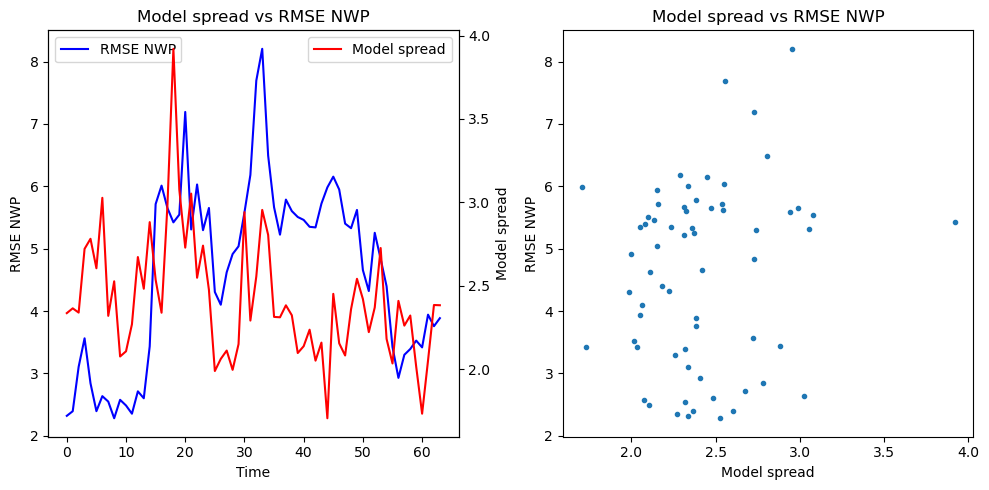

In [61]:

key = 'spread'

x = np.arange(0, len(nwp_skill))

fig, axes = plt.subplots(1,2, figsize=(10,5))

ax1 = axes[0]
ax2 = ax1.twinx()
ax1.set_title(f'Model {key} vs RMSE NWP')

ax1.plot(x, nwp_skill, color='blue', label='RMSE NWP')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')

ax2.set_ylabel(f'Model {key}')
ax2.plot(x, res[key], color='red', label=f'Model {key}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax3 = axes[1]
ax3.plot(res[key], nwp_skill, marker='.', linestyle='')
ax3.set_title(f'Model {key} vs RMSE NWP')
ax3.set_xlabel(f'Model {key}')
ax3.set_ylabel('RMSE NWP')

plt.tight_layout()
plt.show()


### Likelihood

#### Generate first then estimate

In [39]:
def generate_complete_solution_from_single_random(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=complete_edm_sampler, num_steps=20):
    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0)
        current_unbatched = current[0].unsqueeze(0)
        break


    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)
        
        predicted_residuals, predicted_residuals_list = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=num_steps, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * std_residual_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, latents, predicted_residuals_list, current_unnormalized, class_labels

torch.manual_seed(0)
num_steps = 20
n_ens = 10
predicted_unnormalized, latents, predicted_residuals_list, current_unnormalized, class_labels = generate_complete_solution_from_single_random(model, n_ens=n_ens, selected_loader = shuffled_val_loader, sampler_fn=complete_edm_sampler, num_steps=num_steps)

In [ ]:
def likelihood_estimation(model, samples, latents, sample_list, class_labels, eps_multiplier=1, num_steps=20):
    res_list = {}

    ensemble_rmses = calculate_RMSE(samples, current_unnormalized).flatten()

    res = {}
    for j in tqdm(range(n_ens)):
        
        latent = latents[j].unsqueeze(0)
        sample = sample_list[:,j].unsqueeze(1)
        class_label = class_labels[j].unsqueeze(0)

        likelihood = likelihood_estimator(model, 
                                latent,
                                sample, 
                                class_label,
                                eps_multiplier=eps_multiplier,
                                num_steps=num_steps,
                                sigma_max=80, sigma_min=0.03, rho=7, 
                                S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05).item()
        
        print(likelihood, ensemble_rmses[j])
        
        res[np.round(ensemble_rmses[j],3)] = likelihood
            
    sorted_keys = sorted(res.keys())
    sorted_data = [res[key] for key in sorted_keys]

    #plt.boxplot(sorted_data, labels=sorted_keys)
    plt.plot(sorted_keys, sorted_data, marker='o', linewidth=0)

    plt.show()

    return res

res = likelihood_estimation(model, predicted_unnormalized, latents, predicted_residuals_list, class_labels, eps_multiplier=10, num_steps=num_steps)

#### Estimate And Generate

OBS: We can not do the same boxplots as before since we sample at the same time as calculating likelihood
And also not evaluate the effect of eps_multiplier

In [41]:
def generate_and_estimate_likelihood(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=likelihood_sampler, num_steps=20, eps_multiplier=1):

    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0)
        current_unbatched = current[0].unsqueeze(0)
        break

    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)

        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

    predicted_unnormalized_ensemble = torch.zeros((n_ens, 1, previous.size(1), previous.size(2), previous.size(3)), device=device)
    likelihood_ensemble = np.zeros(n_ens)
    rmse_ensemble = np.zeros(n_ens)

    for j in tqdm(range(n_ens)):
        with torch.no_grad():
            latent = latents[j].unsqueeze(0)
            class_label = class_labels[j].unsqueeze(0)

            predicted_residuals, likelihood  = sampler_fn(model, 
                                    latent, 
                                    class_label,
                                    eps_multiplier=eps_multiplier,
                                    num_steps=num_steps,
                                    sigma_max=80, sigma_min=0.03, rho=7, 
                                    S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
            
            predicted_latent = previous_latent + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unnormalized = predicted * std_data + mean_data
            predicted_unnormalized_ensemble[j] = predicted_unnormalized
            likelihood_ensemble[j] = likelihood.item()

            # ----
            ensemble_rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
            
            rmse_ensemble[j] = ensemble_rmse.item()
            print(f"Likelihood {j}: {likelihood.item():.2f}, RMSE {j}: {ensemble_rmse[0]:.2f}")
        
    return predicted_unnormalized_ensemble, current_unnormalized, likelihood_ensemble, rmse_ensemble

 10%|█         | 1/10 [00:17<02:33, 17.09s/it]

Likelihood 0: 3444.49, RMSE 0: 2.88


 20%|██        | 2/10 [00:34<02:16, 17.10s/it]

Likelihood 1: 3415.73, RMSE 1: 2.68


 30%|███       | 3/10 [00:51<01:59, 17.12s/it]

Likelihood 2: 3245.36, RMSE 2: 2.90


 40%|████      | 4/10 [01:08<01:42, 17.10s/it]

Likelihood 3: 3344.98, RMSE 3: 2.39


 50%|█████     | 5/10 [01:25<01:25, 17.15s/it]

Likelihood 4: 3066.87, RMSE 4: 2.33


 60%|██████    | 6/10 [01:42<01:08, 17.18s/it]

Likelihood 5: 3474.93, RMSE 5: 2.32


 70%|███████   | 7/10 [01:59<00:51, 17.15s/it]

Likelihood 6: 3253.71, RMSE 6: 2.31


 80%|████████  | 8/10 [02:17<00:34, 17.19s/it]

Likelihood 7: 3646.79, RMSE 7: 2.88


 90%|█████████ | 9/10 [02:34<00:17, 17.26s/it]

Likelihood 8: 3285.04, RMSE 8: 2.34


100%|██████████| 10/10 [02:52<00:00, 17.23s/it]

Likelihood 9: 3452.50, RMSE 9: 2.23


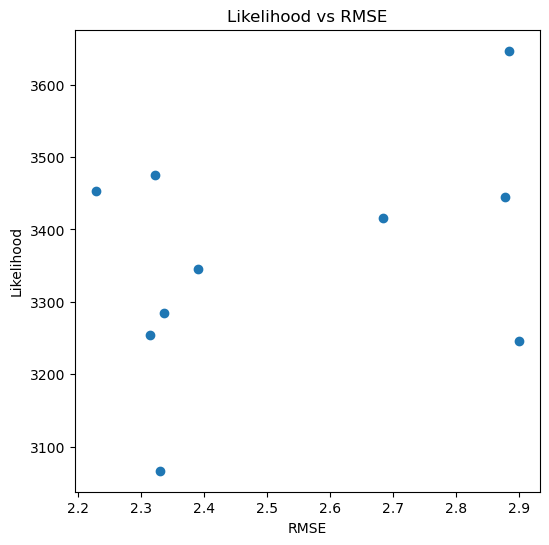

In [53]:
n_ens = 10
eps_multiplier = 20
num_steps = 20

predicted_unnormalized_ensemble, current_unnormalized, likelihood_ensemble, rmse_ensemble = generate_and_estimate_likelihood(model, n_ens=n_ens, selected_loader = shuffled_val_loader, sampler_fn=likelihood_sampler, num_steps=num_steps, eps_multiplier=eps_multiplier)

plt.figure(figsize=(6,6))
plt.xlabel('RMSE')
plt.ylabel('Likelihood')
plt.title('Likelihood vs RMSE')
plt.plot(rmse_ensemble, likelihood_ensemble, marker='o', linestyle='')

#### Sampling + Likelihood as in original paper

Slower than current method.

In [ ]:
from likelihood import get_likelihood_fn

for previous, current in val_loader:
    prev = autoencoder.encoder(previous)[0:10]#.unsqueeze(0)
    curr = autoencoder.encoder(current)[0:10]#.unsqueeze(0)
    break

likelihood_fn = get_likelihood_fn(model, atol=10, rtol=0.1)
res = likelihood_fn(model, curr, prev)
A = res[-1,:]

In [12]:
def generate_forecast_likelihood(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    
    previous = previous.unsqueeze(0)
    previous_latent = autoencoder.encoder(previous)
    
    latents = torch.randn([n_ens, model.img_channels//2, model.img_resolution, model.img_resolution], device=device)
    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
    predicted_latent = class_labels + predicted_residuals * std_residual_latent
    predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
    predicted_unscaled = predicted * std_data + mean_data

    also_sample, logp = likelihood_fn(model, latents, previous_latent)
    also_sample = class_labels + also_sample * std_residual_latent
    also_sample = autoencoder.decoder(also_sample.to(torch.float32))
    also_sample = also_sample * std_data + mean_data

    return predicted_unscaled, also_sample, logp

tensor([-15436.7246], device='cuda:0')


Text(0.5, 1.0, 'Current')

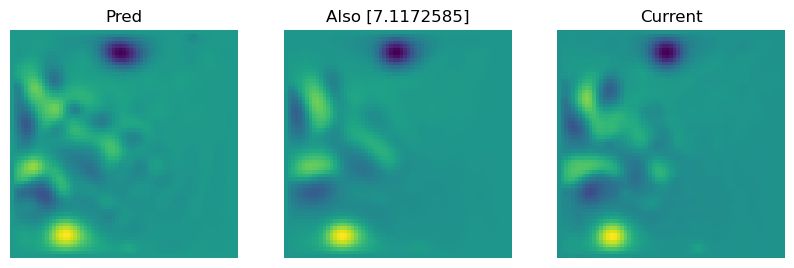

In [137]:
res = generate_forecast_likelihood(model, previous[0], n_ens=1)
pred, also_pred, logp = res
print(logp)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pred.detach().cpu().numpy()[0,0])
axes[0].axis('off')
axes[0].set_title('Pred')

axes[1].imshow(also_pred.detach().cpu().numpy()[0,0])
axes[1].axis('off')
axes[1].set_title(f'Also {((also_pred - current[0])**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()}')


axes[2].imshow(current.detach().cpu().numpy()[0,0])
axes[2].axis('off')
axes[2].set_title('Current')
